In [71]:
import os

import numpy as np
import pandas as pd
import root_pandas
import root_numpy

import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

import xgboost as xgb

from itertools import islice

from tqdm import tqdm

import ROOT

from scripts.data_preparation import get_single_tagging_particles, concat_df_chunks

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 14

# Read in Data from `/net/storage`

In [3]:
data_dir = '/home/kheinicke/tank/flavourtagging/'
filenames = [
    data_dir + 'Bu2JpsiK_MuonTrainingTuple_2012_MD_sweighted_kheinick.root',
    data_dir + 'Bu2JpsiK_MuonTrainingTuple_2012_MU_sweighted_kheinick.root',
]
chunksize = 5000

In [4]:
data_kwargs = dict(
    key='DecayTree',
    columns=['B_OS_Muon*', 'B_*', 'SigYield_sw', 'BkgYield_sw'],
    ignore=['B_ENDVERTEX_COV_',
         'B_OWNPV_COV_',
         'B_TOPPV_COV_',
         'B_OS_E*',
         'B_OS_K*',
         'B_All*',
         'B_Hlt*',
         'B_L0*',
        ],
    chunksize=chunksize,
    where='(B_LOKI_MASS_JpsiConstr_NoPVConstr>0)',
    flatten=True
)

In [5]:
# still have to use plain ROOT to get the number of entries...
n_entries = 0
for fn in filenames:
    f = ROOT.TFile(fn)
    t = f.Get('DecayTree')
    n_entries += t.GetEntries()

In [6]:
if os.path.isfile('muon_max_pt_dataset.root'):
    full_data = root_pandas.read_root('muon_max_pt_dataset.root')
else:
    # This line iterates all data chunks, adds the target column, and chooses the muon with max pt per event
    full_data = get_single_tagging_particles(concat_df_chunks(filenames, **data_kwargs),
                                             lambda x: np.sign(x.B_ID) == np.sign(x.B_OS_Muon_ID),
                                             chunksize=chunksize,
                                             n_entries=n_entries)
    
    # store data to prevent read in every time (~20min)
    root_pandas.to_root(full_data, 'muon_max_pt_dataset.root')

# Define the classic muon tagger features and prepare the training dataset

In [7]:
classic_MVA_features = [
    'B_OS_Muon_countTracks',  # aka mult
    'B_OS_Muon_P',
    'B_OS_Muon_PT',
    'B_PT',
    'B_OS_Muon_ABS_RecVertexIP',  # aka IPs
    'B_OS_Muon_TRCHI2DOF',
    'B_OS_Muon_PROBNNmu',
    'B_OS_Muon_TRGHP',
    'B_OS_Muon_IPPUs',
]

all_muon_features = [c for c in full_data.columns if c.startswith('B_OS_Muon')] + ['B_PT']

In [30]:
classic_data = full_data[all_muon_features + ['target', 'SigYield_sw', 'B_ID']].copy(deep=True)
labels = full_data.target

In [31]:
classic_data.replace([np.inf], 10000, inplace=True)
classic_data.dropna(inplace=True)

In [32]:
# /= 1000 somehow kills the kernel. Maybe a bug in pandas?
classic_data.B_PT *= 0.001
classic_data.B_OS_Muon_P *= 0.001
classic_data.B_OS_Muon_PT *= 0.001

# Apply Muon Selections

In [33]:
before = len(classic_data)
classic_data = classic_data[
    (classic_data.B_OS_Muon_P > 0)
    & (classic_data.B_OS_Muon_PT > 0.5)
    & (classic_data.B_OS_Muon_IsSignalDaughter == 0)
#    & (classic_data.B_OS_Muon_phiDistance > 0.005)
    & (classic_data.B_OS_Muon_MuonPIDIsMuon == 1)
    & (classic_data.B_OS_Muon_TRCHI2DOF < 3)
    & (classic_data['B_OS_Muon_BPVIPCHI2()'] > 0)
    & (classic_data.B_OS_Muon_RecVertexIP > 0)
    & (classic_data.B_OS_Muon_TRGHP < 0.4)
    & (classic_data.B_OS_Muon_PROBNNmu > 0.35)
    & (classic_data.B_OS_Muon_PROBNNpi < 0.8)
    & (classic_data.B_OS_Muon_PROBNNe < 0.8)
    & (classic_data.B_OS_Muon_PROBNNk < 0.8)
    & (classic_data.B_OS_Muon_PROBNNp < 0.8)
#    & (classic_data.SigYield_sw > 0)
]
efficiency = len(classic_data) / before
labels = classic_data.target

print('Efficiency {:2.1f}%'.format(100 * efficiency))

Efficiency 0.6%


In [34]:
classic_data.shape

(5105, 34)

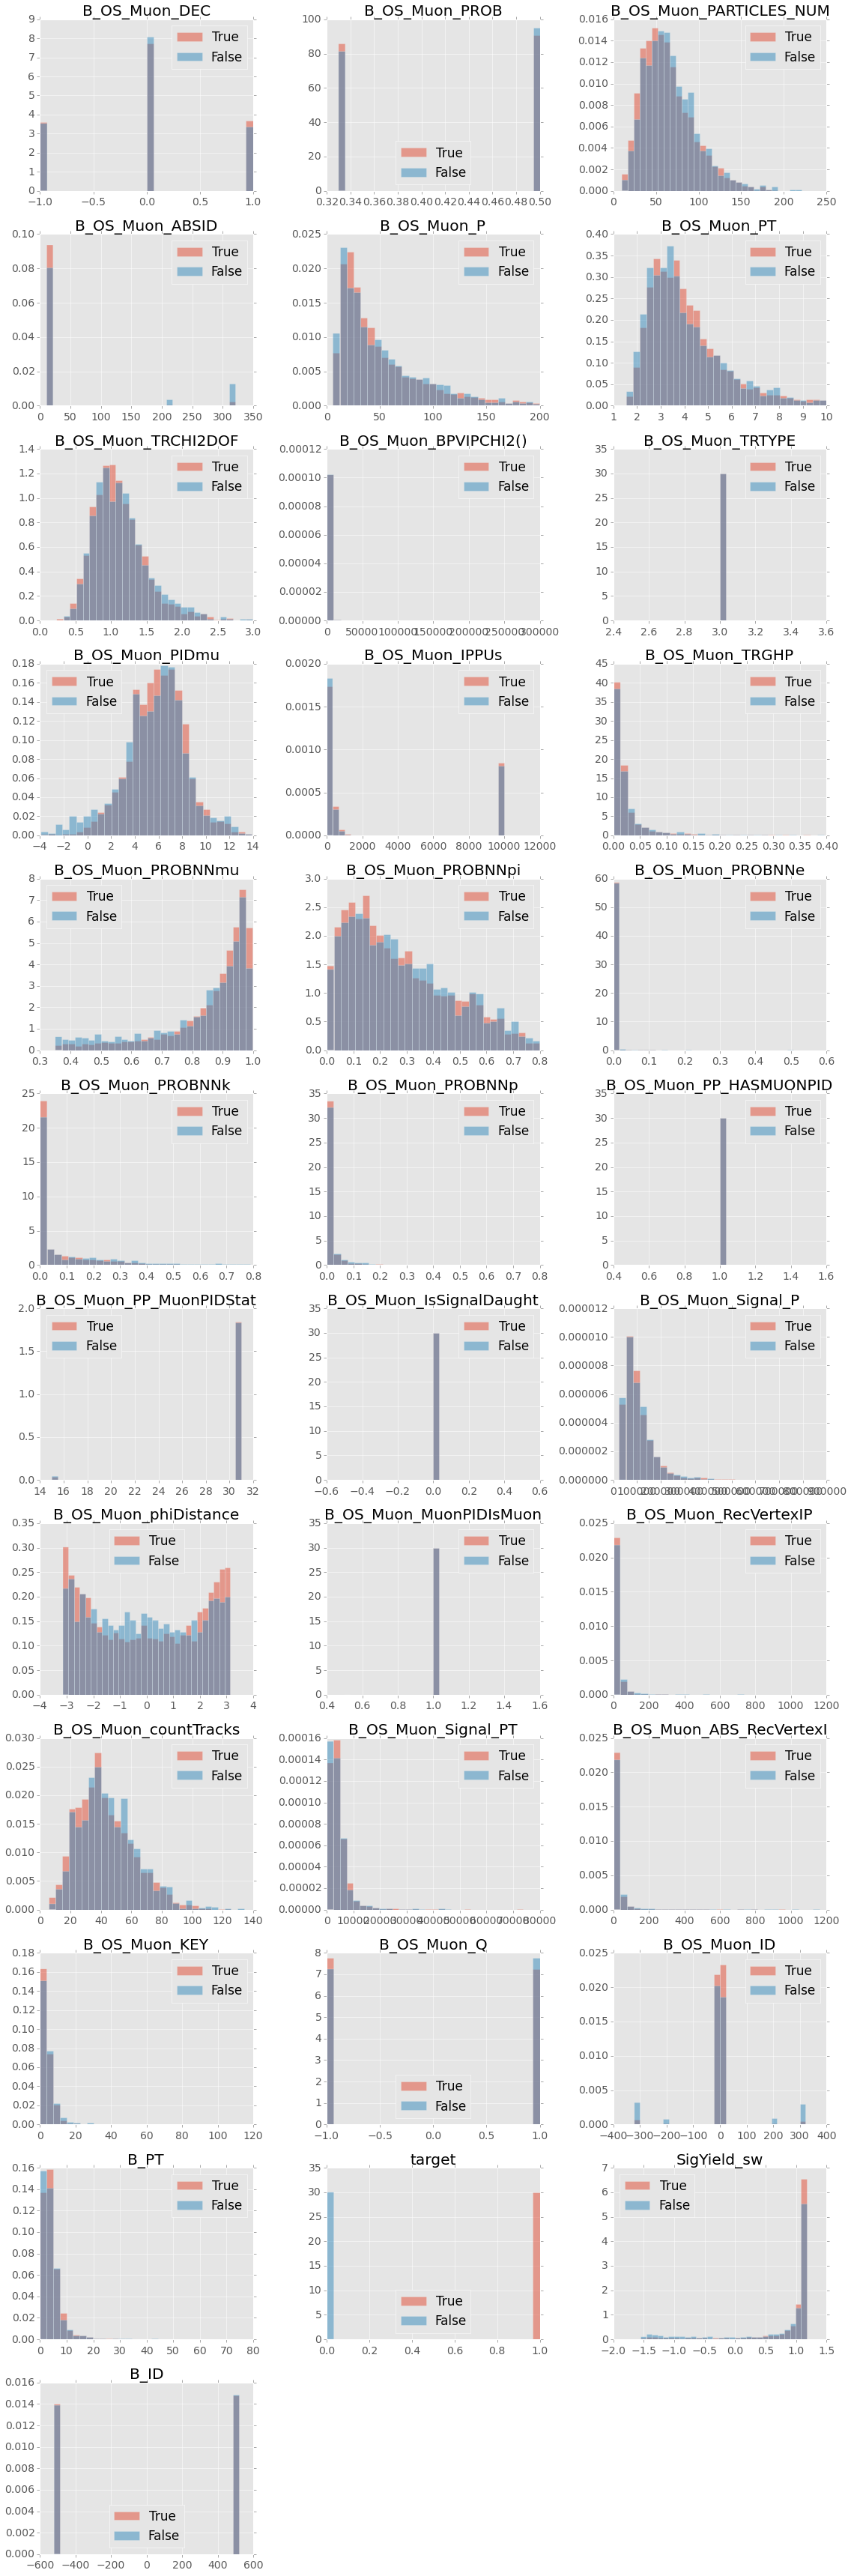

In [73]:
ncols = 3
nrows = np.ceil(len(classic_data.columns)/ncols)
plt.figure(figsize=(16, nrows * 4))
for i, f in enumerate(classic_data.columns):
    plt.subplot(nrows, ncols, i+1)
    _, bins = np.histogram(classic_data[f], 30)
    classic_data[labels==True][f].hist(bins=bins, alpha=0.5, label='True', normed=True)
    classic_data[labels==False][f].hist(bins=bins, alpha=0.5, label='False', normed=True)
    plt.title(f[:24])
    plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Train some Classifiers

In [36]:
def avg_dilution(labels, prediction):
    mistags = labels != (prediction > 0.5)
    omega = np.sum(mistags) / len(labels)
    return 1 - 2*omega

In [48]:
train_data, test_data, train_labels, test_labels = train_test_split(classic_data, labels, test_size=0.3)

In [74]:
xgboost_model = xgb.XGBClassifier(max_depth=5, n_estimators=300, learning_rate=0.01)

In [75]:
xgboost_model.fit(train_data[classic_MVA_features], train_labels)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [76]:
probas = xgboost_model.predict_proba(test_data[classic_MVA_features])[:,1]
preds = xgboost_model.predict(test_data[classic_MVA_features])
score = roc_auc_score(test_labels, probas)

In [77]:
gb = GradientBoostingClassifier()
gb.fit(train_data[classic_MVA_features], train_labels)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [78]:
gb_probas = gb.predict_proba(test_data[classic_MVA_features])[:,1]
gb_score = roc_auc_score(test_labels, gb_probas)

In [84]:
rf = RandomForestClassifier(n_estimators=30)
rf.fit(train_data[classic_MVA_features], train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [85]:
rf_probas = rf.predict_proba(test_data[classic_MVA_features])[:,1]
rf_score = roc_auc_score(test_labels, rf_probas)

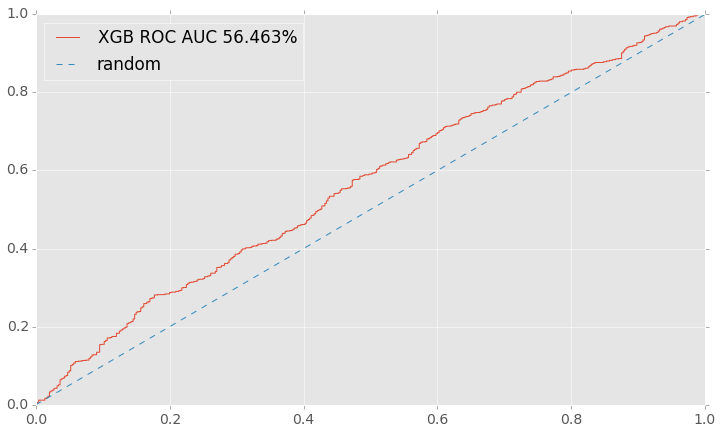

In [89]:
plt.plot(*roc_curve(test_labels, gb_probas)[:2], label='XGB ROC AUC {:2.3f}%'.format(gb_score * 100))
# plt.plot(*roc_curve(test_labels, probas)[:2], label='GB ROC AUC {:2.3f}%'.format(score * 100))
# plt.plot(*roc_curve(test_labels, rf_probas)[:2], label='RF ROC AUC {:2.3f}%'.format(rf_score * 100))
plt.plot([0, 1], '--', label='random')
plt.legend(loc='best')
plt.show()

In [82]:
print('eps_eff = {:2.3f}%'.format(100 * efficiency * avg_dilution(test_labels, probas)**2))

eps_eff = 0.100%


In [83]:
b = gbm.booster()
b.save_model('trained_model.xgb')